In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError
from sklearn.cluster import KMeans

# Database

- Query data - https://www.postgresqltutorial.com/postgresql-python/query/

In [2]:
def query_db(query):
    """ query data from the fitbit database """
    conn = None
    try:
        # set the connection
        conn = create_engine('postgresql://<username>:<password>@localhost/<dbname>', pool_recycle=3600)
        
        # create the dataframe with the query
        df = pd.read_sql(query,con=conn)
        
        # return the dataframe
        return df
    except SQLAlchemyError as e:
        # If a SQLAlchemy exception occurs, handle it here
        print(f'A SQLAlchemy error occurred: {e}')
        
    except (Exception, psycopg2.DatabaseError) as error:
        # If any other exception occurs, handle it here
        print(error)
    finally:
        # Close the database connection in any case
        if conn is not None:
            conn.dispose()

# Loading sleep data

In [3]:
# query to return data for the last year from table sleeps
query = '''SELECT 
                date_of_sleep, start_time, end_time, duration, minutes_after_wakeup, 
                minutes_asleep, minutes_awake, minutes_to_fall_asleep, time_in_bed, deep_sleep, light_sleep, rem_sleep
            FROM 
                sleeps
            WHERE
                date_of_sleep>'2022-01-01';'''

In [4]:
# execute the query and get the result
sleep_df = query_db(query)

In [5]:
sleep_df.head()

,date_of_sleep,start_time,end_time,duration,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_fall_asleep,time_in_bed,deep_sleep,light_sleep,rem_sleep
0,2023-04-03,2023-04-02,2023-04-03,494,1,424,70,0,494,74,300,50
1,2023-04-02,2023-04-02,2023-04-02,280,0,259,21,0,280,52,178,29
2,2023-04-01,2023-03-31,2023-04-01,592,0,512,80,0,592,114,353,45
3,2023-03-31,2023-03-31,2023-03-31,377,0,337,40,0,377,84,240,13
4,2023-03-30,2023-03-30,2023-03-30,444,0,380,64,0,444,74,289,17


### Sleep quality

- https://www.thensf.org/what-is-sleep-quality/

- Sleep efficiency: The amount of time you spend actually sleeping while in bed is known as sleep efficiency. This measurement should ideally be 85 percent or more for optimal health benefits. 
- Sleep quality: how you can calculate it: First find your actual sleeping duration. Take your total time in bed (in minutes) minus how many minutes it took you to fall asleep and minus how many minutes you spent awake during the night. Divide that figure (actual sleeping time) by your total time in bed (in minutes). Finally, multiply that number by 100 to arrive at your sleep efficiency percentage. For example: 480 (total minutes in bed) – 30 (minutes to fall asleep) – 0 (minutes awake during the night) = 450 (actual sleep time in minutes). 450 / 480 = .9375 x 100 = 93.75% sleep efficiency

In [6]:
# create sleep efficiency column
sleep_df['sleep_efficiency'] = round(100*sleep_df['minutes_asleep']/sleep_df['time_in_bed'],2)

In [7]:
# transform the date columns to datetime
sleep_df['date_of_sleep'] = pd.to_datetime(sleep_df['date_of_sleep'])
sleep_df['start_time'] = pd.to_datetime(sleep_df['start_time'])
sleep_df['end_time'] = pd.to_datetime(sleep_df['end_time'])

For the analysis I want to know if moving Countries has affected my sleep and activity levels. For that I will create a variables called 'country' with 1 = Canada. The observations will be segregated since I arrive to Canada and before arriving to Canada.

In [9]:
# Create the country variable
# 1 = Canada
# 0 = Colombia

# date of arrival
date_of_arrival = '2022-08-16'

#create the map
country_code = {0:'Colombia',1:'Canada'}

sleep_df['country'] = np.where(sleep_df['date_of_sleep']>=date_of_arrival,'Canada','Colombia')

In [10]:
# check for cardinality problems
sleep_df.groupby('country').count()

,date_of_sleep,start_time,end_time,duration,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_fall_asleep,time_in_bed,deep_sleep,light_sleep,rem_sleep,sleep_efficiency
country,,,,,,,,,,,,,
Canada,140,140,140,140,140,140,140,140,140,140,140,140,140
Colombia,153,153,153,153,153,153,153,153,153,153,153,153,153


When we're analyzing data, the way it's distributed is really important. If we have too many observations in one group and not enough in another, it can cause issues with our results. We call this "cardinality," and it basically means how balanced the data is across all the different groups we're looking at. So, in this case, we're in luck! The distribution of observations for Canada (140) and Colombia (153) is pretty even, so we don't have to worry about any problems with cardinality. This is great news because it means we can trust the results we get from analyzing this data, and feel confident about any conclusions we draw from it.

In [11]:
# creating a variable with the day of the week
# The day of the week with Monday=0, Sunday=6
sleep_df['day_of_week'] = sleep_df['date_of_sleep'].dt.dayofweek

In order to simplify our task, we filter the initial dataset using the "Country" column and create two distinct datasets, one containing information solely from Colombia and the other from Canada.

In [12]:
# Colombia data
sleep_co_df = sleep_df[sleep_df['country']=='Colombia']

# Canada data
sleep_ca_df = sleep_df[sleep_df['country']=='Canada']

### Descriptive Statistics 

In [13]:
# calculate mean and standard deviation of sleep duration in Colombia and Canada
sleep_stats = sleep_df[['country','duration']].groupby('country').agg(['mean','std'])
sleep_stats

duration           
                mean        std
country                        
Canada    442.892857  60.077970
Colombia  454.045752  56.232054

#### Conclusion

For my first analysis, I can conclude that in Colombia, my mean duration of sleep is 454 minutes (or approximately 7.5 hours), which is slightly longer than in Canada at 442 minutes (or approximately 7.36 hours), with a difference of approximately 12 minutes. However, the standard deviation of my sleep duration is slightly higher in Canada (60 minutes) than in Colombia (56 minutes), suggesting that there is greater variability in sleep duration since I arrived in Canada.

## Visualize sleep data

In [14]:
# set the style
sns.set(style='ticks',palette="pastel")

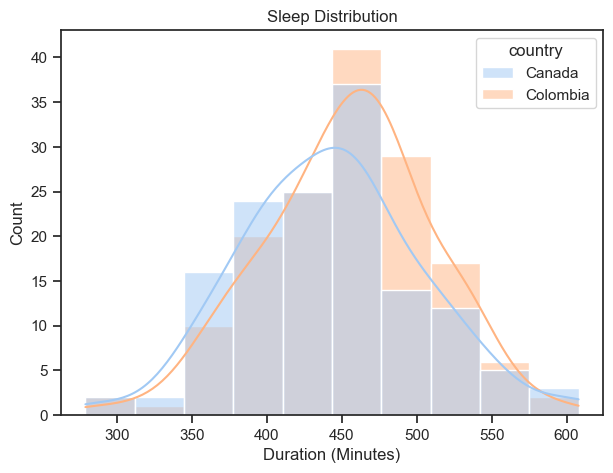

In [17]:
# duration distribution
plt.figure(figsize=(7,5),dpi=100)
graph = sns.histplot(x='duration',data=sleep_df,bins=10,kde=True,hue='country')
plt.title('Sleep Distribution')
plt.xlabel('Duration (Minutes)');

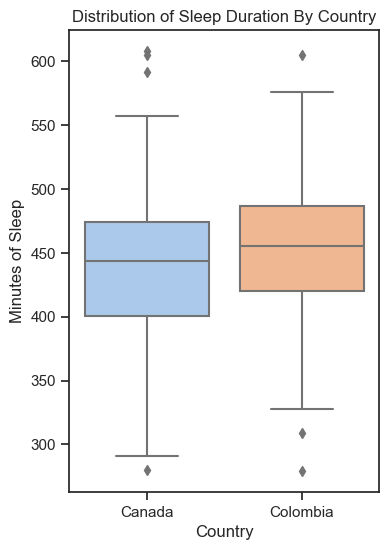

In [18]:
# Boxplot of duratio of sleep by country
plt.figure(figsize=(4,6),dpi=100)
box = sns.boxplot(x='country',y='duration',data=sleep_df)
plt.title('Distribution of Sleep Duration By Country')
plt.ylabel('Minutes of Sleep');
plt.xlabel('Country');

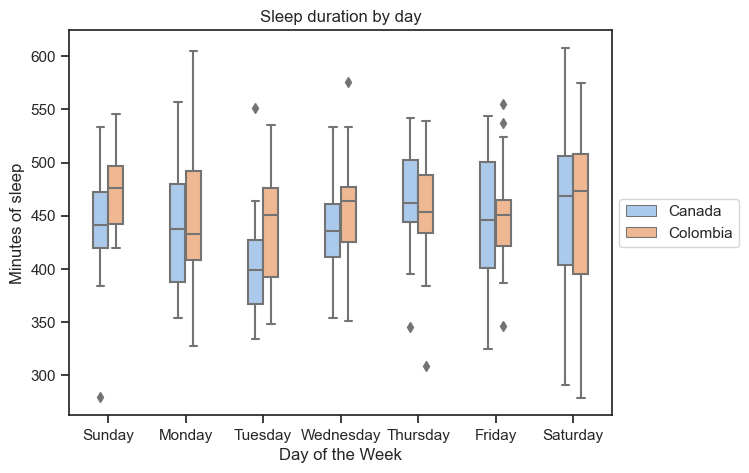

In [20]:
# sleep per day of the week
plt.figure(figsize=(7,5),dpi=100)
sns.boxplot(x=sleep_df['date_of_sleep'].sort_values().dt.day_name(),y='duration', hue='country'
            ,data=sleep_df,width=0.4)
plt.title('Sleep duration by day')
plt.xlabel('Day of the Week')
plt.ylabel('Minutes of sleep')
plt.legend(loc="center left", bbox_to_anchor=(1, 0, .0, 1));

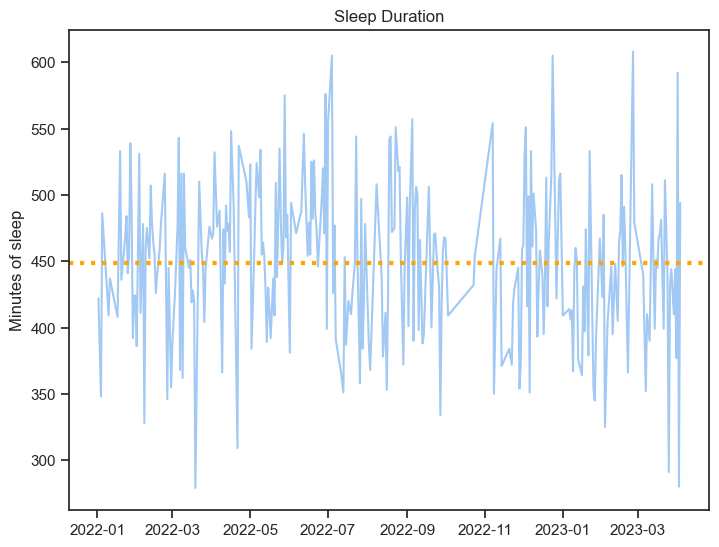

In [21]:
# calculate the mean sleep duration
mean_sleep_duration = sleep_df['duration'].mean()

# Plot the Sleep Duratiion
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot('date_of_sleep','duration',data=sleep_df,label='sleep',)
ax.axhline(y=mean_sleep_duration,color="orange", lw=3, linestyle=':')
plt.title('Sleep Duration')
plt.ylabel('Minutes of sleep');

### Sleep Stages

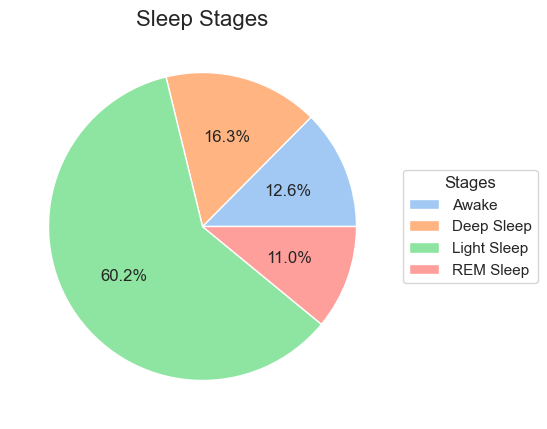

In [22]:
# get sleep stages
sleep_stages = sleep_df[['minutes_awake','deep_sleep','light_sleep','rem_sleep']]

# label the sleep stages
sleep_stages_label = ['Awake','Deep Sleep','Light Sleep','REM Sleep']

# plot the stages
plt.figure(figsize=(5,5),dpi=100)
plt.pie(sleep_stages.mean(),autopct='%1.1f%%',textprops={'fontsize': 12});
plt.title('Sleep Stages', fontsize=16);
plt.legend(labels=sleep_stages_label,title="Stages", loc="center left", bbox_to_anchor=(1, 0, .0, 1));

In [25]:
country_sleep_stages

,country,stage,value
0,Canada,minutes_awake,56.135714
1,Colombia,minutes_awake,56.503268
2,Canada,deep_sleep,72.121429
3,Colombia,deep_sleep,73.607843
4,Canada,light_sleep,265.221429
5,Colombia,light_sleep,274.699346
6,Canada,rem_sleep,48.985714
7,Colombia,rem_sleep,49.235294


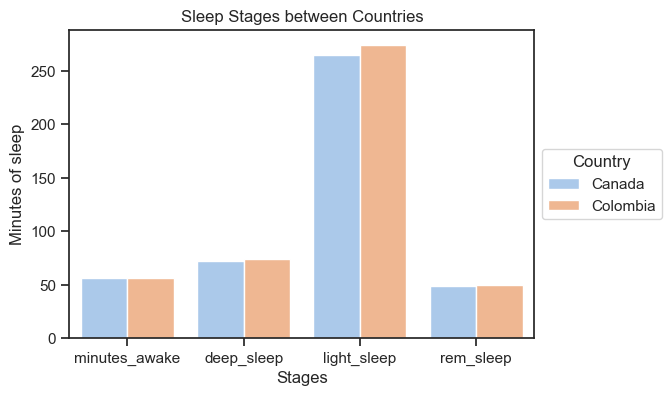

In [107]:
# get the sleep stages mean by country
country_sleep_stages = sleep_df.groupby('country')[['minutes_awake','deep_sleep','light_sleep','rem_sleep']].mean()

# convert the index into a column
country_sleep_stages = country_sleep_stages.reset_index()

# pivot the table
country_sleep_stages = country_sleep_stages.melt(id_vars='country',value_name='value',var_name='stage')

# plot the data
plt.figure(figsize=(6,4),dpi=100)
sns.barplot(x='stage',y='value',hue='country',data=country_sleep_stages,palette='pastel')
plt.title('Sleep Stages between Countries')
plt.xlabel('Stages')
plt.ylabel('Minutes of sleep');
plt.legend(title="Country", loc="center left", bbox_to_anchor=(1, 0, .0, 1));

## Correlations

In [110]:
# calculate Pearson correlation coefficients
sleep_stages_corr = sleep_df[['duration', 'minutes_awake','deep_sleep', 'light_sleep','rem_sleep', 
                              'sleep_efficiency', 'day_of_week']]
correlations = sleep_stages_corr.corr(method='pearson')

# print the correlation coefficients
correlations

,duration,minutes_awake,deep_sleep,light_sleep,rem_sleep,sleep_efficiency,day_of_week
duration,1.000000,0.614510,0.444740,0.744384,0.309900,-0.095016,0.159634
minutes_awake,0.614510,1.000000,0.148593,0.475212,-0.088553,-0.800190,0.067791
deep_sleep,0.444740,0.148593,1.000000,-0.071341,0.255407,0.088592,0.126899
light_sleep,0.744384,0.475212,-0.071341,1.000000,-0.234974,-0.050979,0.042310
rem_sleep,0.309900,-0.088553,0.255407,-0.234974,1.000000,0.282561,0.147865
sleep_efficiency,-0.095016,-0.800190,0.088592,-0.050979,0.282561,1.000000,-0.003698
day_of_week,0.159634,0.067791,0.126899,0.042310,0.147865,-0.003698,1.000000


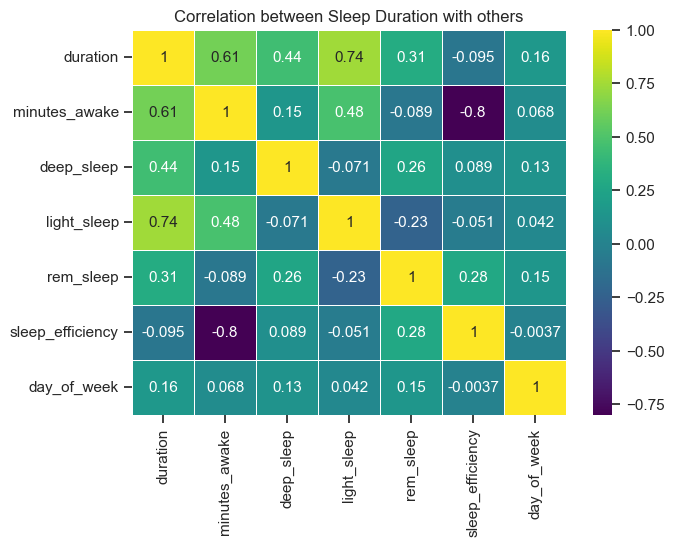

In [109]:
# set the style
plt.figure(figsize=(7,5), dpi=100)
sns.heatmap(correlations,linewidth=0.5,cmap='viridis',annot=True,annot_kws={"size": 11});
plt.title('Correlation between Sleep Duration with others');

### Interpretation:
    
- Sleep duration is positively correlated with time spent in light sleep and REM sleep, and negatively correlated with time spent awake during the night. This suggests that longer sleep duration may be beneficial for achieving a higher amount of light and REM sleep, but may not necessarily result in better quality sleep due to the correlation with being awake during the night.

- Sleep duration is weakly positively correlated with the day of the week. This could indicate that you tend to sleep longer on certain days of the week compared to others.

- Sleep duration is weakly negatively correlated with sleep efficiency. This suggests that longer sleep duration may not necessarily result in better quality sleep, as sleep efficiency measures the percentage of time spent asleep while in bed.

- Overall, the duration of your sleep can provide insights into the different stages of sleep and the quality of your sleep. However, it is important to keep in mind that other factors may also influence your sleep duration, such as your age, lifestyle habits, and sleep environment.

# Modeling

## sleep_df.columns

In [118]:
X = sleep_stages_corr.values

In [119]:
# Use KMeans clustering to identify sleep stages
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
labels = kmeans.labels_

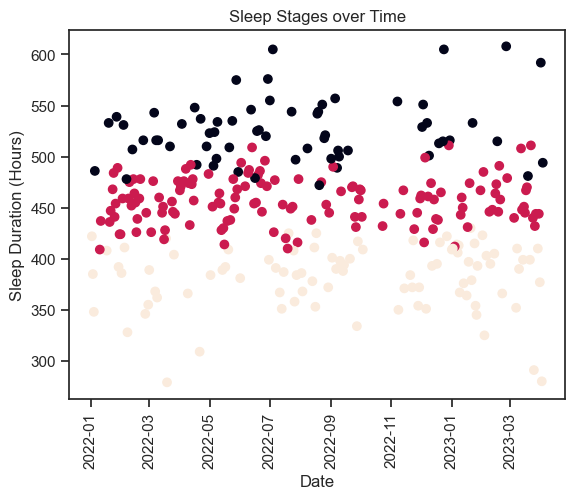

In [120]:
# Create a scatter plot of sleep stages
plt.scatter(sleep_df['date_of_sleep'], sleep_df['duration'], c=labels)
plt.xlabel('Date')
plt.ylabel('Sleep Duration (Hours)')
plt.title('Sleep Stages over Time')
plt.xticks(rotation='vertical')
plt.show()

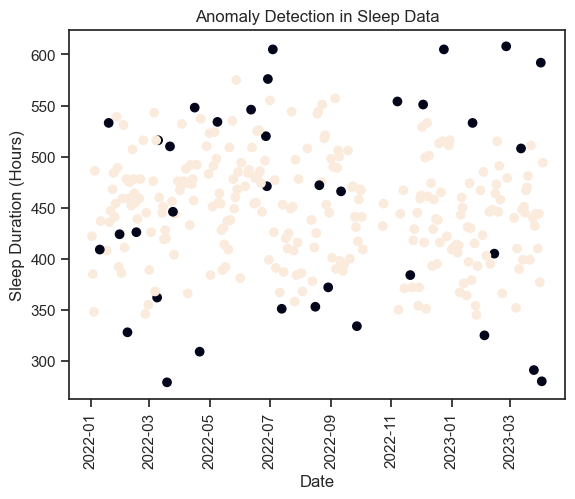

In [121]:
# Use IsolationForest to detect anomalies in sleep data
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), max_features=1.0)
clf.fit(X)
pred = clf.predict(X)

# Create a scatter plot of sleep data with anomalies highlighted
plt.scatter(sleep_df['date_of_sleep'], sleep_df['duration'], c=pred)
plt.xlabel('Date')
plt.ylabel('Sleep Duration (Hours)')
plt.title('Anomaly Detection in Sleep Data')
plt.xticks(rotation='vertical')
plt.show()

# Loading hear rate data

In [129]:
# query to recover data from heart_rates table
query = 'SELECT date_time, resting_heart_rate FROM heart_rates;'

In [130]:
# create the dataframe for heart rate
hr_df = query_db(query)

In [135]:
hr_df.head()

,date_time,resting_heart_rate
0,2022-04-04,46
1,2022-04-05,47
2,2022-04-06,48
3,2022-04-07,48
4,2022-04-08,48


In [132]:
# tranforming date columns to datetime
hr_df['date_time'] = pd.to_datetime(hr_df['date_time'])

<AxesSubplot:xlabel='resting_heart_rate', ylabel='Count'>

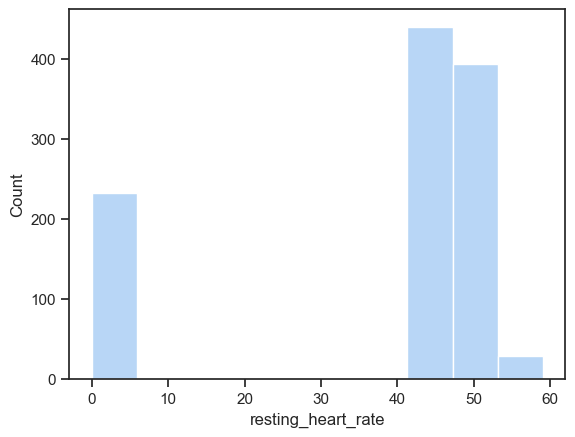

In [133]:
sns.histplot(hr_df['resting_heart_rate'],bins=10)

In [136]:
hr_df['resting_heart_rate'].describe()

count    1096.000000
mean       37.534672
std        19.620060
min         0.000000
25%        43.000000
50%        46.000000
75%        49.000000
max        59.000000
Name: resting_heart_rate, dtype: float64

In [137]:
# deleting observations for resting_heart_rate = 0
hr_df = hr_df.drop(index=hr_df[hr_df['resting_heart_rate']<= 0].index, axis=0)

# Loading steps data

In [139]:
# query to recover data from steps table
query = 'SELECT date_time, steps FROM steps;'

In [140]:
# create the dataframe for steps
steps_df = query_db(query)

In [141]:
steps_df['date_time'] = pd.to_datetime(steps_df['date_time'])

<AxesSubplot:xlabel='steps', ylabel='Count'>

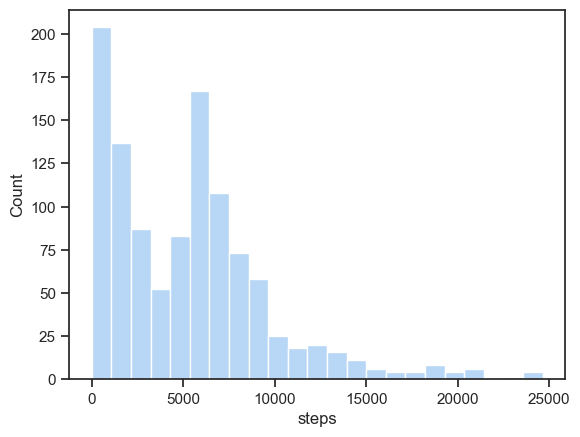

In [142]:
sns.histplot(steps_df['steps'])

# Loading activities data

In [723]:
# query to recover data from steps table
query = '''SELECT 
                start_date, name, start_time, steps, duration, calories
            FROM
                activities
            WHERE
                start_date >= \'2022-01-01\';'''

# create the dataframe for activities
activities_df = query_db(query)

In [724]:
# create the column timestamp with the start_date and start_time
activities_df['timestamp'] = pd.to_datetime(activities_df['start_date'].map(str) +' '+ activities_df['start_time'].map(str))

# set columns to datatime
activities_df['start_date'] = pd.to_datetime(activities_df['start_date'])

# strip white spaces for name
activities_df['name'] = activities_df['name'].str.strip()

# converting duration from miliseconds to minutes
activities_df['duration'] = round(activities_df['duration']/(1000*60))

In [725]:
activities_df.head()

,start_date,name,start_time,steps,duration,calories,timestamp
0,2023-04-02,Treadmill,13:14,1764,13.0,131,2023-04-02 13:14:00
1,2023-04-02,Weights,13:28,1076,43.0,294,2023-04-02 13:28:00
2,2023-04-02,Walk,15:27,6732,62.0,472,2023-04-02 15:27:00
3,2023-04-02,Walk,17:17,5070,65.0,382,2023-04-02 17:17:00
4,2023-03-31,Walk,14:25,1015,17.0,95,2023-03-31 14:25:00


### Activities since arriving to Canada

In [726]:
# Add the country varibles
activities_df['country'] = np.where(activities_df['start_date']>=date_of_arrival,'Canada','Colombia')

In [727]:
# activities after arriving to Canada
activities_ca = activities_df[activities_df['country']=='Canada']

# activities before arriving to Canada
activities_co = activities_df[activities_df['country']=='Colombia']

# Adding the column week
activities_ca.loc[:,'week'] = activities_ca['start_date'].dt.isocalendar().week
activities_co.loc[:,'week'] = activities_co['start_date'].dt.isocalendar().week

C:\Users\leona\AppData\Local\Temp\ipykernel_18832\3275188210.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activities_ca.loc[:,'week'] = activities_ca['start_date'].dt.isocalendar().week
C:\Users\leona\AppData\Local\Temp\ipykernel_18832\3275188210.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activities_co.loc[:,'week'] = activities_co['start_date'].dt.isocalendar().week


#### Checking for Cardinality issues

In [728]:
# check cardinality per activity for CO
activities_co.groupby('name').size()

name
Circuit Training    17
Outdoor Bike        41
Run                  4
Sport                2
Treadmill           64
Walk                40
Weights             68
dtype: int64

In [729]:
# there is unbalance with Run and Sport. I need to get ride of these observations

# select the index of those rows
row_index = activities_co[activities_co['name'].isin(['Run','Sport'])].index

# drop the indexes
activities_co = activities_co.drop(index=row_index)

In [730]:
# check cardinality per activity for CA
activities_ca.groupby('name').size()

name
Aerobic Workout      1
Circuit Training     1
Outdoor Bike        16
Sport                1
Treadmill           47
Walk                87
Weights             49
dtype: int64

In [731]:
# there is unbalance with Aerobic Workout, Circuit Training and Sport. I need to get ride of these observations

# select the index of those rows
row_index = activities_ca[activities_ca['name'].isin(['Aerobic Workout','Circuit Training','Sport'])].index

# drop the indexes
activities_ca = activities_ca.drop(index=row_index)

In [732]:
# Create DF week activities
week_activity_co = activities_co[['country','week']].drop_duplicates()

# Muscle strengthening activities in CO
strength = activities_co[activities_co['name']=='Weights'].groupby('week').size()
strength = strength.rename('strength_exercise_count')

# Cardio activities in CA
cardio = activities_co[activities_co['name']!='Weights'].groupby('week')['duration'].sum()
cardio = cardio.rename('cardio_mins')

# Merge activities with strength
week_activity_co = pd.merge(week_activity_co,strength,how='left',on='week')

# Merge activities with Cardio
week_activity_co = pd.merge(week_activity_co,cardio,how='left',on='week')

In [733]:
# Create DF week activities
week_activity_ca = activities_ca[['country','week']].drop_duplicates()

# Muscle strengthening activities in CA
strength = activities_ca[activities_ca['name']=='Weights'].groupby('week').size()
strength = strength.rename('strength_exercise_count')


# Cardio activities in CA
cardio = activities_ca[activities_ca['name']!='Weights'].groupby('week')['duration'].sum()
cardio = cardio.rename('cardio_mins')

# Merge activities with strength
week_activity_ca = pd.merge(week_activity_ca,strength,how='left',on='week')

# Merge activities with Cardio
week_activity_ca = pd.merge(week_activity_ca,cardio,how='left',on='week')

In [734]:
# Concat week_activity_co and week_activity_ca
week_activity = pd.concat([week_activity_co,week_activity_ca],axis=0,ignore_index=True)

In [735]:
# fill null values
week_activity[['strength_exercise_count', 'cardio_mins']] = week_activity[['strength_exercise_count', 'cardio_mins']].fillna(0)

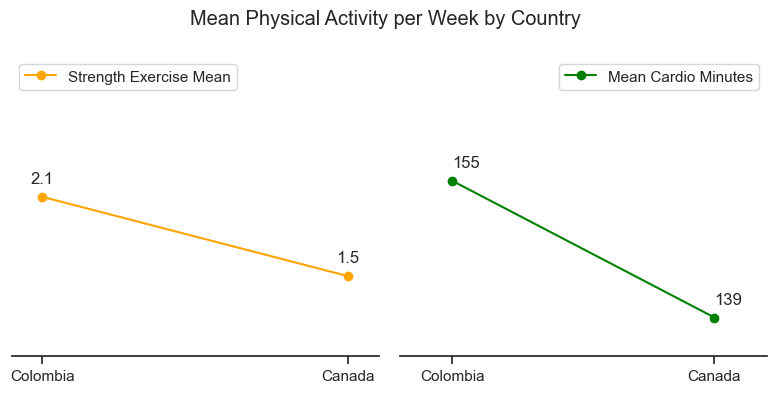

In [736]:
mean_country = week_activity.groupby(['country']).mean(['strength_exercise_count','cardio_mins']).reset_index()
mean_country = mean_country.sort_values('country',ascending=False)
mean_country = mean_country.rename(columns={'country':'Country', 'strength_exercise_count':'Strength Exercise Mean',
                                           'cardio_mins':'Mean Cardio Minutes'})

# Create the subplots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4),dpi=100)

plt.suptitle('Mean Physical Activity per Week by Country')

# Create the slope line for strength_exercise_count
axes[0].plot('Country','Strength Exercise Mean',data=mean_country, marker='o', color='orange')
axes[0].set_xlim([-0.1, 1.1])
axes[0].set_xticks([0, 1])
axes[0].set_ylim([1, 3])
#axes[0].set_ylabel('Mean Strength Exercise')
axes[0].spines["right"].set_color("none")
axes[0].spines["top"].set_color("none")
axes[0].spines["left"].set_color("none")
axes[0].tick_params(axis='y', length=0, labelleft=False)
axes[0].legend(loc='upper left')
for i, count in enumerate(mean_country["Strength Exercise Mean"]):
    axes[0].annotate(f"{count:.1f}", (i, count), textcoords="offset points", xytext=(0, 10), ha='center')

    
# Create the slope line for cardio_mins
axes[1].plot('Country','Mean Cardio Minutes',data=mean_country,marker='o', color='green')
axes[1].set_xlim([-0.2, 1.2])
axes[1].set_xticks([0, 1])
axes[1].set_ylim([135, 170])
#axes[1].set_yticks([135, 150,170])
#axes[1].set_ylabel('Mean Cardio Minutes')
axes[1].tick_params(axis='y', length=0, labelleft=False)
axes[1].legend(loc='upper right')
for i, count in enumerate(mean_country["Mean Cardio Minutes"]):
    axes[1].annotate(f"{count:.0f}", (i, count), textcoords="offset points", xytext=(10, 10), ha='center')
axes[1].spines["right"].set_color("none")
axes[1].spines["top"].set_color("none")
axes[1].spines["left"].set_color("none")
#axes[1].spines["bottom"].set_position(("data", -0.1))
plt.tight_layout()

In [774]:
# activities after arriving to Canada
activity_data_ca = activities_ca.groupby('name').sum()['calories'].reset_index()
activity_data_ca = activity_data_ca.sort_values(by='calories',ascending=False).nlargest(n=4,columns='calories')

# activities before arriving to Canada
activity_data_co = activities_co.groupby('name').sum()['calories'].reset_index()
activity_data_co = activity_data_co.sort_values(by='calories',ascending=False).nlargest(n=4,columns='calories')

In [796]:
# replace Outdoor Bike with Circuit Training because I have been selecting the wrong category while exercising
activity_data_ca.loc[activity_data_ca['name']=='Outdoor Bike','name'] = 'Circuit Training'

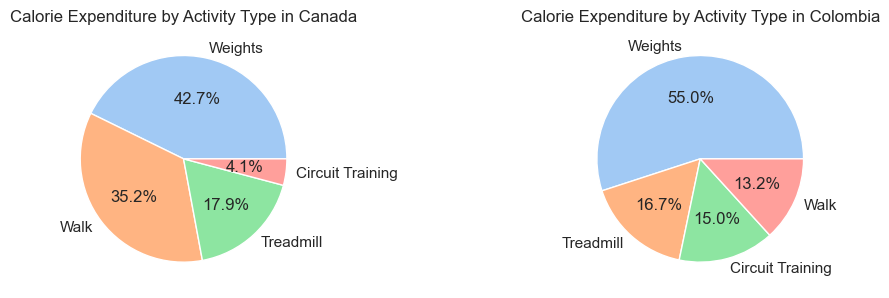

In [799]:
# create a pie chart of calorie expenditure by activity type
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10, 10), dpi=100)
axes[0].pie(activity_data_ca['calories'], labels=activity_data_ca['name'], autopct='%1.1f%%')
axes[0].set_title("Calorie Expenditure by Activity Type in Canada")
axes[1].pie(activity_data_co['calories'], labels=activity_data_co['name'], autopct='%1.1f%%')
axes[1].set_title("Calorie Expenditure by Activity Type in Colombia")
plt.subplots_adjust(wspace=1)
plt.show();

In [809]:
# add the column country
activity_data_ca['country'] = 'Canada'
activity_data_co['country'] = 'Colombia'

# concat in a single dataframe
activity_data = pd.concat([activity_data_co,activity_data_ca], ignore_index=True)

In [870]:
activity_data.groupby('country')[['calories']].sum()

,calories
country,
Canada,47742
Colombia,61768


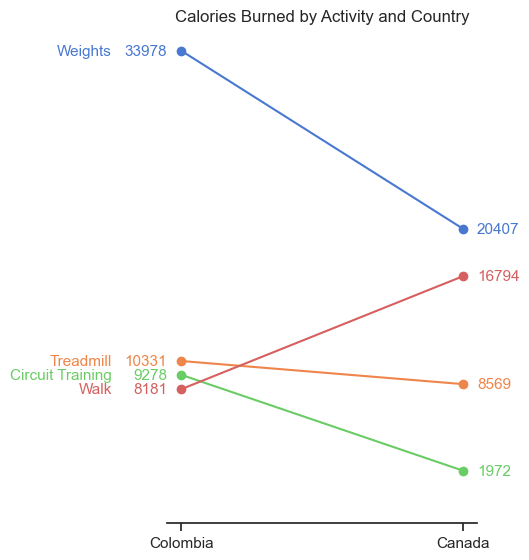

In [868]:
# set the style
sns.set(style='ticks',palette="muted")
# create a dictionary to store the data for each name
data_dict = {}
for name in activity_data['name'].unique():
    data_dict[name] = activity_data.loc[activity_data['name'] == name]


# create a dictionary to store the data for each name
data_dict = {}
for name in activity_data['name'].unique():
    data_dict[name] = activity_data.loc[activity_data['name'] == name]

# create the plot
fig, ax = plt.subplots(figsize=(4, 6),dpi=100)
ax.set_title('Calories Burned by Activity and Country')

# iterate over the dictionary and plot the lines
for name, data in data_dict.items():
    line = ax.plot(data['country'], data['calories'], marker='o', label=name)
    
    # iterate over the data and add the value labels
    for i, row in data.iterrows():
        if row['country'] == 'Colombia':
            ax.annotate(str(row['calories']), xy=(row['country'], row['calories']), xytext=(-10, -3), 
                        textcoords='offset points', ha='right', color=line[0].get_color(),fontsize=11)
        else:
            ax.annotate(str(row['calories']), xy=(row['country'], row['calories']), xytext=(10, -3), 
                        textcoords='offset points', color=line[0].get_color(),fontsize=11)

    # add the legend to the left of the line
    legend_x = line[0].get_xdata()[0]
    legend_y = line[0].get_ydata()[0]
    ax.annotate(name, xy=(legend_x, legend_y), xytext=(-50, -3), textcoords='offset points', ha='right', 
                color=line[0].get_color(),fontsize=11)

# hide the top, left, and right axes lines
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines["bottom"].set_position(("data", -2000))

# hide the ticks and line in the y axis
ax.tick_params(axis='y', length=0, width=0,labelleft=False)

# remove the horizontal lines
ax.grid(False)

# show the plot
plt.show()

### Calories

In [871]:
# calculate mean and standard deviation of calorie expenditure after arriving to Canada
mean_calories = activities_ca['calories'].mean()
std_calories = activities_ca['calories'].std()

print("Mean calories burned: ", mean_calories)
print("Standard deviation of calories burned: ", std_calories)

Mean calories burned:  239.90954773869348
Standard deviation of calories burned:  172.6963583319218


In [872]:
# calculate mean and standard deviation of calorie expenditure before arriving to Canada
mean_calories = activities_co['calories'].mean()
std_calories = activities_co['calories'].std()

print("Mean calories burned: ", mean_calories)
print("Standard deviation of calories burned: ", std_calories)

Mean calories burned:  298.1434782608696
Standard deviation of calories burned:  203.57602428749988


### Run for Your Life (and Your Waistline)

In [873]:
# activities after arriving to Canada
#activities_ca = activities_df[activities_df['start_date']>='2022-08-16']
activity_calories = activities_ca.groupby('name').sum()[['calories','duration']].reset_index()
activity_calories = activity_calories.sort_values(by='calories',ascending=False).nlargest(n=3,columns='calories')
activity_calories['calories_per_minute']=round(activity_calories['calories']/activity_calories['duration'],2)
#activities_ca = activity_data_ca.sort_values(by='calories',ascending=False).nlargest(n=5,columns='calories')

In [874]:
activity_calories= activity_calories.sort_values(by='calories_per_minute',ascending=False)

In [875]:
activity_calories

,name,calories,duration,calories_per_minute
1,Treadmill,8569,1129.0,7.59
2,Walk,16794,2579.0,6.51
3,Weights,20407,3919.0,5.21


Text(0, 0.5, 'Calories burned per minute')

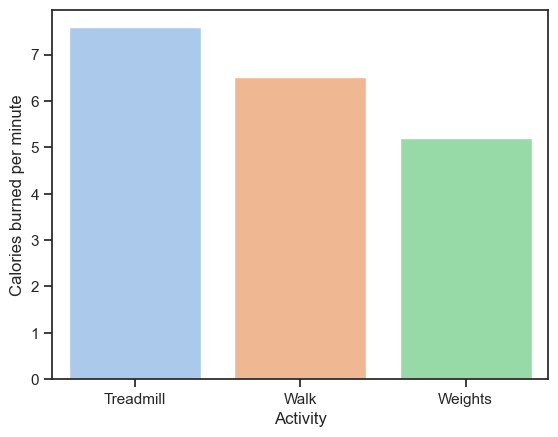

In [877]:
# set the style
sns.set(style='ticks',palette="pastel")
plt.figure()
sns.barplot(x='name',y='calories_per_minute',data=activity_calories)
plt.xlabel('Activity')
plt.ylabel('Calories burned per minute')

#### Conclusion

In conclusion, the analysis of the efficiency of different types of exercise provides valuable insights for optimizing my workout routines. The data shows that treadmill workouts burn the most calories per minute, while weightlifting and walking are also effective forms of exercise. However, it is important to remember that the effectiveness of any exercise program depends on individual factors and goals.

In [878]:
activities_ca['name'].value_counts().nlargest(n=3)

Walk         87
Weights      49
Treadmill    47
Name: name, dtype: int64

<AxesSubplot:xlabel='count', ylabel='name'>

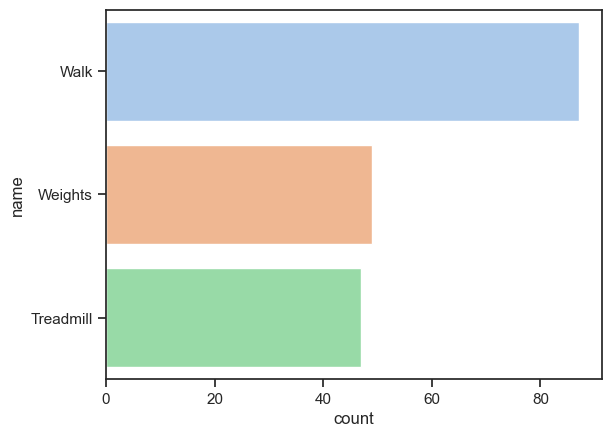

In [879]:
# most popular activity
sns.countplot(y='name',data=activities_ca,order=activities_ca['name'].value_counts().nlargest(n=3).index,orient="h")
#plt.xticks(rotation='vertical');

# Activities summary

In [924]:
# Bring the activity records from 2022-01-01
query = '''SELECT 
                date_activity, steps, marginal_calories, activity_calories, calories_bmr, 
                calories_out, resting_heart_rate, sedentary_minutes, fairly_active_minutes, lightly_active_minutes, 
                very_active_minutes
            FROM 
                activities_summary
            WHERE
                date_activity>=\'2022-01-01\'
        '''
summary_df = query_db(query)

In [925]:
# convert date_activity to datetime
summary_df['date_activity'] = pd.to_datetime(summary_df['date_activity'])

In [926]:
#drop duplicates
summary_df = summary_df.drop_duplicates(subset=['date_activity'])

# Create the country variable
#summary_df['country'] = np.where(summary_df['date_activity']>=date_of_arrival,'Canada','Colombia')

# Ceate the week column
summary_df['week'] = summary_df.date_activity.dt.isocalendar().week

In [927]:
summary_df.head()

,date_activity,steps,marginal_calories,activity_calories,calories_bmr,calories_out,resting_heart_rate,sedentary_minutes,fairly_active_minutes,lightly_active_minutes,very_active_minutes,week
0,2023-04-02,17910,1216,1864,1629,3188,47,823,28,178,131,13
1,2023-04-01,1655,133,349,1629,1907,45,738,0,110,0,13
2,2023-03-31,10653,837,1432,1629,2867,45,755,25,271,12,13
3,2023-03-30,7663,377,616,1629,2215,45,874,22,82,18,13
4,2023-03-29,9266,673,1223,1629,2684,44,750,11,250,19,13


# Merging Sleep and activity summary

In [931]:
# Merge the two dataset by the date
sleep_activity_df = pd.merge(sleep_df,summary_df,how='inner',left_on='date_of_sleep',right_on='date_activity')

In [932]:
sleep_activity_df.head()

,date_of_sleep,start_time,end_time,duration,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_fall_asleep,time_in_bed,deep_sleep,...,marginal_calories,activity_calories,calories_bmr,calories_out,resting_heart_rate,sedentary_minutes,fairly_active_minutes,lightly_active_minutes,very_active_minutes,week
0,2023-04-02,2023-04-02,2023-04-02,280,0,259,21,0,280,52,...,1216,1864,1629,3188,47,823,28,178,131,13
1,2023-04-01,2023-03-31,2023-04-01,592,0,512,80,0,592,114,...,133,349,1629,1907,45,738,0,110,0,13
2,2023-03-31,2023-03-31,2023-03-31,377,0,337,40,0,377,84,...,837,1432,1629,2867,45,755,25,271,12,13
3,2023-03-30,2023-03-30,2023-03-30,444,0,380,64,0,444,74,...,377,616,1629,2215,45,874,22,82,18,13
4,2023-03-29,2023-03-29,2023-03-29,410,0,371,39,0,410,79,...,673,1223,1629,2684,44,750,11,250,19,13


In [910]:
sleep_activity_df.to_csv('sleep_activity.csv',index=False)

In [935]:
# create the sleep activity dataframe since arriving to Canada
sa_ca_df = sleep_activity_df[sleep_activity_df['country']=='Canada']
sa_ca_df = sa_ca_df
# create the sleep activity datafram before arriving to Canada
sa_co_df = sleep_activity_df[sleep_activity_df['country']=='Colombia']

In [967]:
sleep_activity_corr = sa_ca_df[['date_of_sleep', 'duration','steps', 'activity_calories','sedentary_minutes', 
                                'fairly_active_minutes', 'lightly_active_minutes','very_active_minutes']]

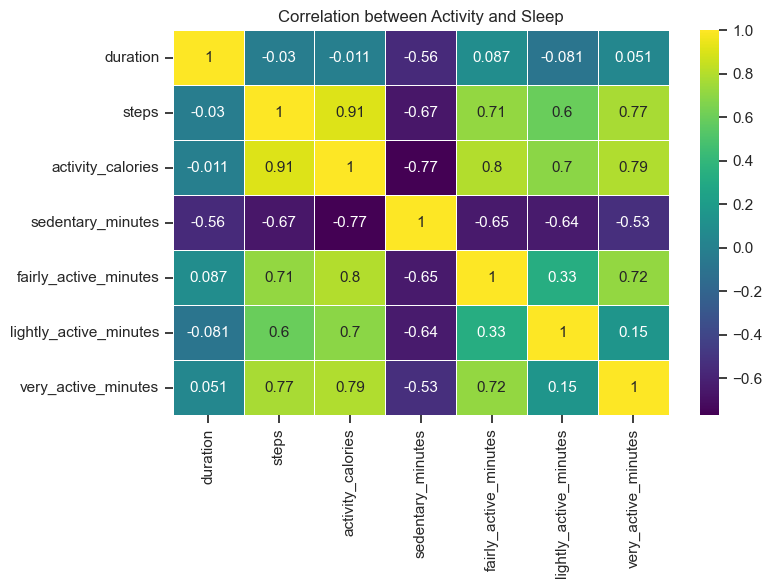

In [973]:
# set the style
plt.figure(figsize=(8,5), dpi=100)
sns.heatmap(sleep_activity_corr.corr(),linewidth=0.5,cmap='viridis',annot=True,annot_kws={"size": 11});
plt.title('Correlation between Activity and Sleep');